<a href="https://colab.research.google.com/github/jiku100/2020-2-machine-running-proejct/blob/master/assignment9/%EC%8B%A0%EC%84%9D%EA%B2%BD_assignment_09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Classification for Multiple Categories using Pytorch**



# 1. Import library
<hr>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import cv2
import numpy as np

In [2]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("다음 기기로 학습합니다:", device)

다음 기기로 학습합니다: cuda


# 2. Load Data
<hr>

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,)),  # mean value = 0.1307, standard deviation value = 0.3081
])

In [4]:
data_path = './MNIST'

training_set = datasets.MNIST(root = data_path, train= True, download=True, transform= transform)
testing_set = datasets.MNIST(root = data_path, train= False, download=True, transform= transform)

In [5]:
batch_32 = 32
batch_64 = 64
batch_128 = 128
learning_rate_value = 1e-2

In [6]:
train_loader_32 = DataLoader(dataset = training_set, batch_size = batch_32, shuffle = True) ## batch size 32 짜리 train loader 생성
test_loader_32 = DataLoader(dataset = testing_set, batch_size = batch_32, shuffle = True) ## batch size 32 짜리 test loader 생성

train_loader_64 = DataLoader(dataset = training_set, batch_size = batch_64, shuffle = True) ## batch size 64 짜리 train loader 생성
test_loader_64 = DataLoader(dataset = testing_set, batch_size = batch_64, shuffle = True) ## batch size 64 짜리 test loader 생성

train_loader_128 = DataLoader(dataset = training_set, batch_size = batch_128, shuffle = True) ## batch size 128 짜리 train loader 생성
test_loader_128 = DataLoader(dataset = testing_set, batch_size = batch_128, shuffle = True) ## batch size 128 짜리 test loader 생성

Target: 5


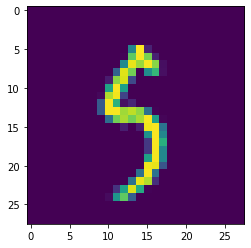

In [7]:
for X, Y in train_loader_64:
  plt.imshow(X[0][0].numpy())
  print(f"Target: {Y[0]}")
  break

# 3. Define Model
<hr>

In [8]:
class classification(nn.Module):
    def __init__(self):
        super(classification, self).__init__()
        
        # construct layers for a neural network
        self.classifier1 = nn.Sequential(
            nn.Linear(in_features=28*28, out_features=20*20),
            nn.Sigmoid(),
        ) 
        self.classifier2 = nn.Sequential(
            nn.Linear(in_features=20*20, out_features=10*10),
            nn.Sigmoid(),
        ) 
        self.classifier3 = nn.Sequential(
            nn.Linear(in_features=10*10, out_features=10),
            nn.LogSoftmax(dim=1),
        ) 
        
        
    def forward(self, inputs):                 # [batchSize, 1, 28, 28]
        x = inputs.view(inputs.size(0), -1)    # [batchSize, 28*28]
        x = self.classifier1(x)                # [batchSize, 20*20]
        x = self.classifier2(x)                # [batchSize, 10*10]
        out = self.classifier3(x)              # [batchSize, 10]
        
        return out


In [9]:
classifier_32 = classification().to(device)
classifier_64 = classification().to(device)
classifier_128 = classification().to(device)

In [23]:
## Loss function
criterion = nn.NLLLoss()

# Optimization
optimizer_32 = torch.optim.SGD(classifier_32.parameters(), lr=learning_rate_value)
optimizer_64 = torch.optim.SGD(classifier_64.parameters(), lr=learning_rate_value)
optimizer_128 = torch.optim.SGD(classifier_128.parameters(), lr=learning_rate_value)

# 4. Training
<hr>

In [11]:
training_epochs = 60
total_batch_32 = len(train_loader_32)
total_batch_64 = len(train_loader_64)
total_batch_128 = len(train_loader_128)

In [12]:
print(total_batch_64)

938


In [13]:
def accuracy(log_pred, y_true):
    y_pred = torch.argmax(log_pred, dim=1)
    return (y_pred == y_true).to(torch.float).mean()

In [14]:
for X, Y in train_loader_32:
  X = X.to(device)
  Y = Y.to(device)
  pred = classifier_32(X)
  print(torch.argmax(pred, dim=1))
  print(Y)
  print((torch.argmax(pred, dim=1) == Y).to(torch.float).mean())
  break

tensor([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 1, 7, 7, 1, 7, 7], device='cuda:0')
tensor([1, 8, 5, 7, 3, 7, 5, 5, 6, 1, 9, 6, 9, 3, 8, 6, 9, 9, 1, 5, 2, 7, 5, 9,
        5, 4, 5, 6, 8, 8, 6, 1], device='cuda:0')
tensor(0.0938, device='cuda:0')


In [15]:
def training(model, loss, optim, training_epochs, train_loader, test_loader):
  L_iters_train = []
  accuracy_train = []
  L_iters_test = []
  accuracy_test = []
  for epoch in range(training_epochs):
    total_cost_train = 0
    total_cost_test = 0
    total_acc_train = 0
    total_acc_test = 0

    for X, Y in train_loader:
      X = X.to(device)
      Y = Y.to(device)

      optim.zero_grad()
      train_pred = model(X)
      cost = loss(train_pred, Y)
      cost.backward()
      optim.step()
      total_cost_train += cost
      total_acc_train += accuracy(train_pred, Y)
      
    avg_cost_train = total_cost_train / len(train_loader)
    avg_acc_train = total_acc_train / len(train_loader)

    L_iters_train.append(avg_cost_train)
    accuracy_train.append(avg_acc_train)
    with torch.no_grad():
      for X_test, Y_test in test_loader:
        X_test = X_test.to(device)
        Y_test = Y_test.to(device)
        test_pred = model(X_test)
        cost_test = loss(test_pred, Y_test)
        total_cost_test += cost_test
        total_acc_test += accuracy(test_pred, Y_test)
      avg_cost_test = total_cost_test / len(test_loader)
      avg_acc_test = total_acc_test / len(test_loader)
    
      accuracy_test.append(avg_acc_test)
      L_iters_test.append(avg_cost_test)

    print("Epoch: %02d Training Loss: %.9f Testing Loss: %.9f  Training Acc: %.9f Testing Acc: %.9f" %((epoch + 1),avg_cost_train, avg_cost_test, avg_acc_train, avg_acc_test))
  return L_iters_train, accuracy_train, L_iters_test, accuracy_test

In [16]:
L_train_32, A_train_32, L_test_32, A_test_32 = training(classifier_32, criterion, optimizer_32, training_epochs, train_loader_32, test_loader_32)

Epoch: 01 Training Loss: 2.149753332 Testing Loss: 1.775298119  Training Acc: 0.329466671 Testing Acc: 0.573881805
Epoch: 02 Training Loss: 1.254785538 Testing Loss: 0.873651087  Training Acc: 0.683183312 Testing Acc: 0.779752374
Epoch: 03 Training Loss: 0.714236379 Testing Loss: 0.575361133  Training Acc: 0.814116657 Testing Acc: 0.846445680
Epoch: 04 Training Loss: 0.523175359 Testing Loss: 0.455460310  Training Acc: 0.858283341 Testing Acc: 0.874400914
Epoch: 05 Training Loss: 0.435686976 Testing Loss: 0.391868144  Training Acc: 0.880283356 Testing Acc: 0.893170893
Epoch: 06 Training Loss: 0.386093795 Testing Loss: 0.356098950  Training Acc: 0.892849982 Testing Acc: 0.900858581
Epoch: 07 Training Loss: 0.354180843 Testing Loss: 0.329601020  Training Acc: 0.900749981 Testing Acc: 0.906749189
Epoch: 08 Training Loss: 0.331518441 Testing Loss: 0.310821027  Training Acc: 0.905933321 Testing Acc: 0.911841035
Epoch: 09 Training Loss: 0.313635260 Testing Loss: 0.296942800  Training Acc: 0.

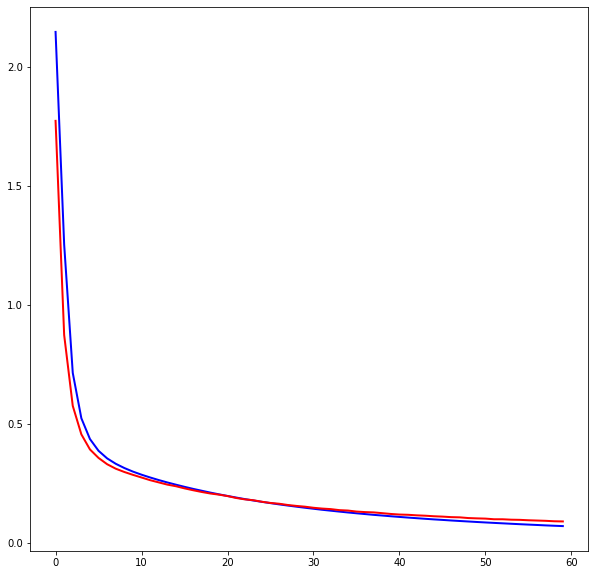

In [17]:
plt.figure(figsize = (10,10))
plt.plot(L_train_32, linewidth = 2, c='b')
plt.plot(L_test_32, linewidth = 2, c='r')
plt.show()

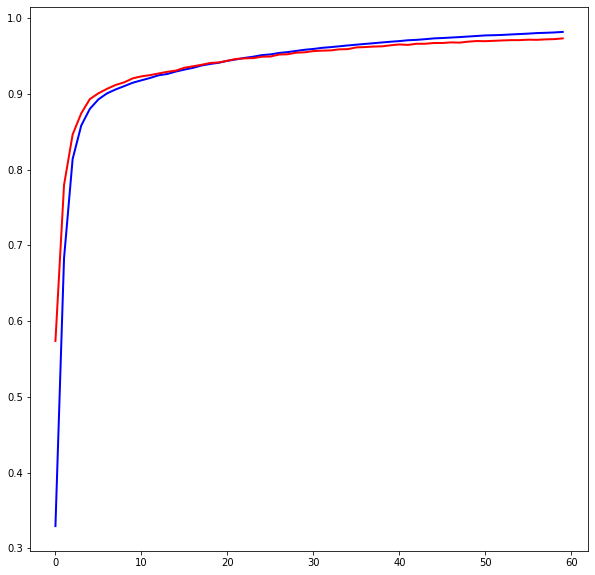

In [18]:
plt.figure(figsize = (10,10))
plt.plot(A_train_32, linewidth = 2, c='b')
plt.plot(A_test_32, linewidth = 2, c='r')
plt.show()

In [24]:
L_train_64, A_train_64, L_test_64, A_test_64 = training(classifier_64, criterion, optimizer_64, training_epochs, train_loader_64, test_loader_64)

Epoch: 01 Training Loss: 2.267910004 Testing Loss: 2.217391491  Training Acc: 0.218416855 Testing Acc: 0.399382979
Epoch: 02 Training Loss: 2.082724810 Testing Loss: 1.850738406  Training Acc: 0.494802773 Testing Acc: 0.541500807
Epoch: 03 Training Loss: 1.540864468 Testing Loss: 1.254214406  Training Acc: 0.613173008 Testing Acc: 0.686007202
Epoch: 04 Training Loss: 1.076659918 Testing Loss: 0.913942218  Training Acc: 0.720965505 Testing Acc: 0.767217398
Epoch: 05 Training Loss: 0.818406224 Testing Loss: 0.715586901  Training Acc: 0.789145827 Testing Acc: 0.819168031
Epoch: 06 Training Loss: 0.662578464 Testing Loss: 0.594166517  Training Acc: 0.829507589 Testing Acc: 0.846934736
Epoch: 07 Training Loss: 0.565106630 Testing Loss: 0.513381124  Training Acc: 0.851212680 Testing Acc: 0.865843952
Epoch: 08 Training Loss: 0.501844525 Testing Loss: 0.462934166  Training Acc: 0.865655005 Testing Acc: 0.874203861
Epoch: 09 Training Loss: 0.457541347 Testing Loss: 0.424871266  Training Acc: 0.

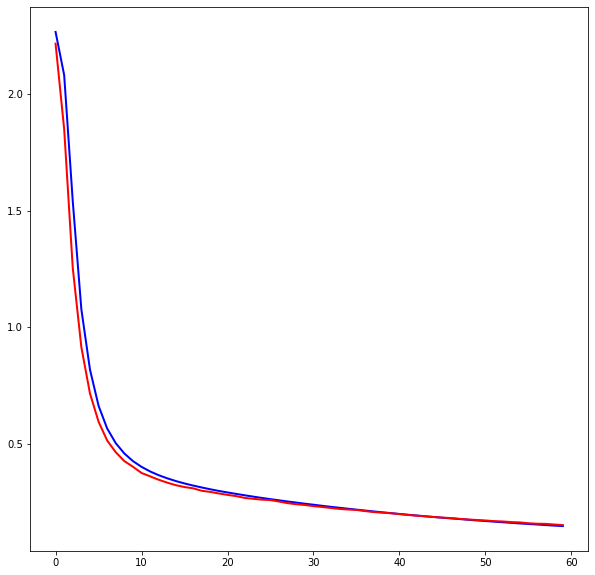

In [25]:
plt.figure(figsize = (10,10))
plt.plot(L_train_64, linewidth = 2, c='b')
plt.plot(L_test_64, linewidth = 2, c='r')
plt.show()

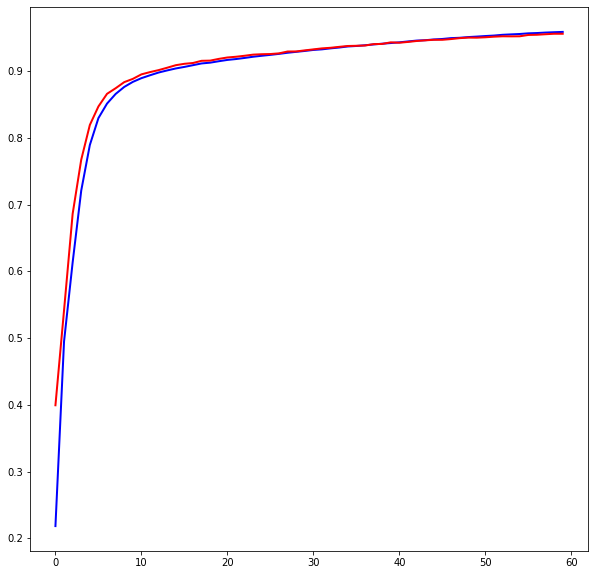

In [26]:
plt.figure(figsize = (10,10))
plt.plot(A_train_64, linewidth = 2, c='b')
plt.plot(A_test_64, linewidth = 2, c='r')
plt.show()

In [27]:
L_train_128, A_train_128, L_test_128, A_test_128 = training(classifier_128, criterion, optimizer_128, training_epochs, train_loader_128, test_loader_128)

Epoch: 01 Training Loss: 2.283799887 Testing Loss: 2.263685942  Training Acc: 0.140747160 Testing Acc: 0.263844937
Epoch: 02 Training Loss: 2.238509893 Testing Loss: 2.204364061  Training Acc: 0.307913542 Testing Acc: 0.422369480
Epoch: 03 Training Loss: 2.149590015 Testing Loss: 2.069040775  Training Acc: 0.477584213 Testing Acc: 0.530953348
Epoch: 04 Training Loss: 1.947384357 Testing Loss: 1.785430908  Training Acc: 0.552316606 Testing Acc: 0.585443079
Epoch: 05 Training Loss: 1.626077414 Testing Loss: 1.454366326  Training Acc: 0.598214328 Testing Acc: 0.642800629
Epoch: 06 Training Loss: 1.331399679 Testing Loss: 1.201330185  Training Acc: 0.657305002 Testing Acc: 0.691851258
Epoch: 07 Training Loss: 1.113745213 Testing Loss: 1.015234590  Training Acc: 0.709099650 Testing Acc: 0.733682752
Epoch: 08 Training Loss: 0.957674146 Testing Loss: 0.885669470  Training Acc: 0.749689043 Testing Acc: 0.770668507
Epoch: 09 Training Loss: 0.843126416 Testing Loss: 0.783169806  Training Acc: 0.

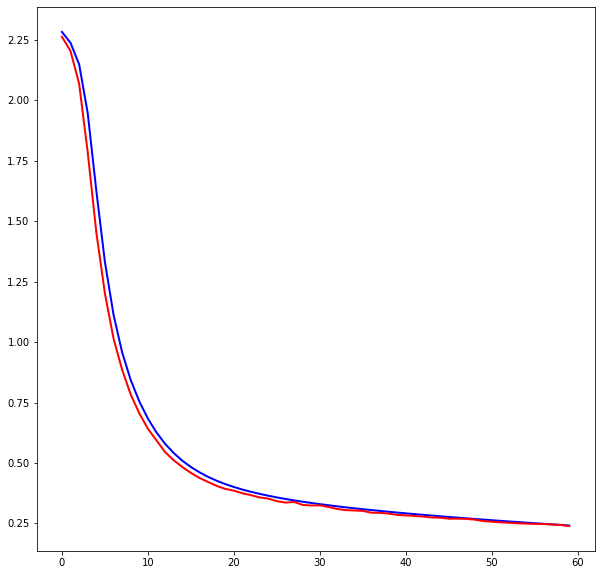

In [28]:
plt.figure(figsize = (10,10))
plt.plot(L_train_128, linewidth = 2, c='b')
plt.plot(L_test_128, linewidth = 2, c='r')
plt.show()

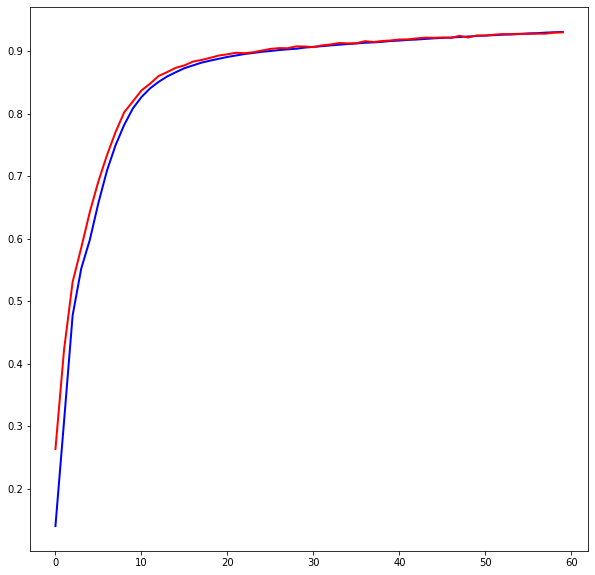

In [29]:
plt.figure(figsize = (10,10))
plt.plot(A_train_128, linewidth = 2, c='b')
plt.plot(A_test_128, linewidth = 2, c='r')
plt.show()